## Autonomous Driving (Part 1)

In this assignment, the goal is to prepare training data for learning to drive autonomously. The assignment will be conducted only on simulated data. For that reason, We will use two simulator examples from [Gymnasium](https://gymnasium.farama.org). Gym is a framework for developing reinforcement learning approaches. It supports different types of agents. Here, we will focus on vehicles.

*Important*: You need to install [Gymnasium](https://gymnasium.farama.org) in your system. The installation can be done with pip or by installing from the sources. More information at [https://pypi.org/project/gymnasium/](https://pypi.org/project/gymnasium/).



## 1. Car Racing Simulation

In this exercise, a car drives a route in a racing environment. The car can turn left, right, accelerate or decelerate. The input is an image with 96x96 pixels. In addition, rewards are given based on the driving behavior. We are not interested in the rewards in this task. The task of this exercise is to make use of the demo code for driving the racing car and produce training data.
 
*Task Output*: A training set of 5000 images should be generated in this task. You can make use of the car_racing.py example from the [Gym examples](https://gymnasium.farama.org/environments/box2d/car_racing/) to setup a playing simulator. By playing the simulator, you could create 5000 frames and corresponding ground-truth. The ground-truth is simply the control option. The ground-truth can be stored as one-hot vector. The data should include diversity because they will be later used for training a deep neural network.


In [2]:
pip install gymnasium
pip install gymnasium[box2d]

In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torchvision.transforms.functional as F
from PIL import Image

In [42]:
__credits__ = ["Andrea PIERRÉ"]

import math
from typing import Optional, Union

import numpy as np

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.box2d.car_dynamics import Car
from gymnasium.error import DependencyNotInstalled, InvalidAction
from gymnasium.utils import EzPickle


try:
    import Box2D
    from Box2D.b2 import contactListener, fixtureDef, polygonShape
except ImportError as e:
    raise DependencyNotInstalled(
        "Box2D is not installed, run `pip install gymnasium[box2d]`"
    ) from e

try:
    # As pygame is necessary for using the environment (reset and step) even without a render mode
    #   therefore, pygame is a necessary import for the environment.
    import pygame
    from pygame import gfxdraw
except ImportError as e:
    raise DependencyNotInstalled(
        "pygame is not installed, run `pip install gymnasium[box2d]`"
    ) from e


STATE_W = 96  # less than Atari 160x192
STATE_H = 96
VIDEO_W = 600
VIDEO_H = 400
WINDOW_W = 1000
WINDOW_H = 800

SCALE = 6.0  # Track scale
TRACK_RAD = 900 / SCALE  # Track is heavily morphed circle with this radius
PLAYFIELD = 2000 / SCALE  # Game over boundary
FPS = 50  # Frames per second
ZOOM = 2.7  # Camera zoom
ZOOM_FOLLOW = True  # Set to False for fixed view (don't use zoom)


TRACK_DETAIL_STEP = 21 / SCALE
TRACK_TURN_RATE = 0.31
TRACK_WIDTH = 40 / SCALE
BORDER = 8 / SCALE
BORDER_MIN_COUNT = 4
GRASS_DIM = PLAYFIELD / 20.0
MAX_SHAPE_DIM = (
    max(GRASS_DIM, TRACK_WIDTH, TRACK_DETAIL_STEP) * math.sqrt(2) * ZOOM * SCALE
)


class FrictionDetector(contactListener):
    def __init__(self, env, lap_complete_percent):
        contactListener.__init__(self)
        self.env = env
        self.lap_complete_percent = lap_complete_percent

    def BeginContact(self, contact):
        self._contact(contact, True)

    def EndContact(self, contact):
        self._contact(contact, False)

    def _contact(self, contact, begin):
        tile = None
        obj = None
        u1 = contact.fixtureA.body.userData
        u2 = contact.fixtureB.body.userData
        if u1 and "road_friction" in u1.__dict__:
            tile = u1
            obj = u2
        if u2 and "road_friction" in u2.__dict__:
            tile = u2
            obj = u1
        if not tile:
            return

        # inherit tile color from env
        tile.color[:] = self.env.road_color
        if not obj or "tiles" not in obj.__dict__:
            return
        if begin:
            obj.tiles.add(tile)
            if not tile.road_visited:
                tile.road_visited = True
                self.env.reward += 1000.0 / len(self.env.track)
                self.env.tile_visited_count += 1

                # Lap is considered completed if enough % of the track was covered
                if (
                    tile.idx == 0
                    and self.env.tile_visited_count / len(self.env.track)
                    > self.lap_complete_percent
                ):
                    self.env.new_lap = True
        else:
            obj.tiles.remove(tile)


class CarRacing(gym.Env, EzPickle):
    """
    ## Description
    The easiest control task to learn from pixels - a top-down
    racing environment. The generated track is random every episode.

    Some indicators are shown at the bottom of the window along with the
    state RGB buffer. From left to right: true speed, four ABS sensors,
    steering wheel position, and gyroscope.
    To play yourself (it's rather fast for humans), type:
    ```
    python gymnasium/envs/box2d/car_racing.py
    ```
    Remember: it's a powerful rear-wheel drive car - don't press the accelerator
    and turn at the same time.

    ## Action Space
    If continuous there are 3 actions :
    - 0: steering, -1 is full left, +1 is full right
    - 1: gas
    - 2: breaking

    If discrete there are 5 actions:
    - 0: do nothing
    - 1: steer left
    - 2: steer right
    - 3: gas
    - 4: brake

    ## Observation Space

    A top-down 96x96 RGB image of the car and race track.

    ## Rewards
    The reward is -0.1 every frame and +1000/N for every track tile visited,
    where N is the total number of tiles visited in the track. For example,
    if you have finished in 732 frames, your reward is
    1000 - 0.1*732 = 926.8 points.

    ## Starting State
    The car starts at rest in the center of the road.

    ## Episode Termination
    The episode finishes when all the tiles are visited. The car can also go
    outside the playfield - that is, far off the track, in which case it will
    receive -100 reward and die.

    ## Arguments
    `lap_complete_percent` dictates the percentage of tiles that must be visited by
    the agent before a lap is considered complete.

    Passing `domain_randomize=True` enables the domain randomized variant of the environment.
    In this scenario, the background and track colours are different on every reset.

    Passing `continuous=False` converts the environment to use discrete action space.
    The discrete action space has 5 actions: [do nothing, left, right, gas, brake].

    ## Reset Arguments
    Passing the option `options["randomize"] = True` will change the current colour of the environment on demand.
    Correspondingly, passing the option `options["randomize"] = False` will not change the current colour of the environment.
    `domain_randomize` must be `True` on init for this argument to work.
    Example usage:
    ```python
    import gymnasium as gym
    env = gym.make("CarRacing-v1", domain_randomize=True)

    # normal reset, this changes the colour scheme by default
    env.reset()

    # reset with colour scheme change
    env.reset(options={"randomize": True})

    # reset with no colour scheme change
    env.reset(options={"randomize": False})
    ```

    ## Version History
    - v1: Change track completion logic and add domain randomization (0.24.0)
    - v0: Original version

    ## References
    - Chris Campbell (2014), http://www.iforce2d.net/b2dtut/top-down-car.

    ## Credits
    Created by Oleg Klimov
    """

    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "state_pixels",
        ],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        verbose: bool = False,
        lap_complete_percent: float = 0.95,
        domain_randomize: bool = False,
        continuous: bool = True,
    ):
        EzPickle.__init__(
            self,
            render_mode,
            verbose,
            lap_complete_percent,
            domain_randomize,
            continuous,
        )
        self.continuous = continuous
        self.domain_randomize = domain_randomize
        self.lap_complete_percent = lap_complete_percent
        self._init_colors()

        self.contactListener_keepref = FrictionDetector(self, self.lap_complete_percent)
        self.world = Box2D.b2World((0, 0), contactListener=self.contactListener_keepref)
        self.screen: Optional[pygame.Surface] = None
        self.surf = None
        self.clock = None
        self.isopen = True
        self.invisible_state_window = None
        self.invisible_video_window = None
        self.road = None
        self.car: Optional[Car] = None
        self.reward = 0.0
        self.prev_reward = 0.0
        self.verbose = verbose
        self.new_lap = False
        self.fd_tile = fixtureDef(
            shape=polygonShape(vertices=[(0, 0), (1, 0), (1, -1), (0, -1)])
        )

        # This will throw a warning in tests/envs/test_envs in utils/env_checker.py as the space is not symmetric
        #   or normalised however this is not possible here so ignore
        if self.continuous:
            self.action_space = spaces.Box(
                np.array([-1, 0, 0]).astype(np.float32),
                np.array([+1, +1, +1]).astype(np.float32),
            )  # steer, gas, brake
        else:
            self.action_space = spaces.Discrete(5)
            # do nothing, left, right, gas, brake

        self.observation_space = spaces.Box(
            low=0, high=255, shape=(STATE_H, STATE_W, 3), dtype=np.uint8
        )

        self.render_mode = render_mode

    def _destroy(self):
        if not self.road:
            return
        for t in self.road:
            self.world.DestroyBody(t)
        self.road = []
        assert self.car is not None
        self.car.destroy()

    def _init_colors(self):
        if self.domain_randomize:
            # domain randomize the bg and grass colour
            self.road_color = self.np_random.uniform(0, 210, size=3)

            self.bg_color = self.np_random.uniform(0, 210, size=3)

            self.grass_color = np.copy(self.bg_color)
            idx = self.np_random.integers(3)
            self.grass_color[idx] += 20
        else:
            # default colours
            self.road_color = np.array([102, 102, 102])
            self.bg_color = np.array([102, 204, 102])
            self.grass_color = np.array([102, 230, 102])

    def _reinit_colors(self, randomize):
        assert (
            self.domain_randomize
        ), "domain_randomize must be True to use this function."

        if randomize:
            # domain randomize the bg and grass colour
            self.road_color = self.np_random.uniform(0, 210, size=3)

            self.bg_color = self.np_random.uniform(0, 210, size=3)

            self.grass_color = np.copy(self.bg_color)
            idx = self.np_random.integers(3)
            self.grass_color[idx] += 20

    def _create_track(self):
        CHECKPOINTS = 12

        # Create checkpoints
        checkpoints = []
        for c in range(CHECKPOINTS):
            noise = self.np_random.uniform(0, 2 * math.pi * 1 / CHECKPOINTS)
            alpha = 2 * math.pi * c / CHECKPOINTS + noise
            rad = self.np_random.uniform(TRACK_RAD / 3, TRACK_RAD)

            if c == 0:
                alpha = 0
                rad = 1.5 * TRACK_RAD
            if c == CHECKPOINTS - 1:
                alpha = 2 * math.pi * c / CHECKPOINTS
                self.start_alpha = 2 * math.pi * (-0.5) / CHECKPOINTS
                rad = 1.5 * TRACK_RAD

            checkpoints.append((alpha, rad * math.cos(alpha), rad * math.sin(alpha)))
        self.road = []

        # Go from one checkpoint to another to create track
        x, y, beta = 1.5 * TRACK_RAD, 0, 0
        dest_i = 0
        laps = 0
        track = []
        no_freeze = 2500
        visited_other_side = False
        while True:
            alpha = math.atan2(y, x)
            if visited_other_side and alpha > 0:
                laps += 1
                visited_other_side = False
            if alpha < 0:
                visited_other_side = True
                alpha += 2 * math.pi

            while True:  # Find destination from checkpoints
                failed = True

                while True:
                    dest_alpha, dest_x, dest_y = checkpoints[dest_i % len(checkpoints)]
                    if alpha <= dest_alpha:
                        failed = False
                        break
                    dest_i += 1
                    if dest_i % len(checkpoints) == 0:
                        break

                if not failed:
                    break

                alpha -= 2 * math.pi
                continue

            r1x = math.cos(beta)
            r1y = math.sin(beta)
            p1x = -r1y
            p1y = r1x
            dest_dx = dest_x - x  # vector towards destination
            dest_dy = dest_y - y
            # destination vector projected on rad:
            proj = r1x * dest_dx + r1y * dest_dy
            while beta - alpha > 1.5 * math.pi:
                beta -= 2 * math.pi
            while beta - alpha < -1.5 * math.pi:
                beta += 2 * math.pi
            prev_beta = beta
            proj *= SCALE
            if proj > 0.3:
                beta -= min(TRACK_TURN_RATE, abs(0.001 * proj))
            if proj < -0.3:
                beta += min(TRACK_TURN_RATE, abs(0.001 * proj))
            x += p1x * TRACK_DETAIL_STEP
            y += p1y * TRACK_DETAIL_STEP
            track.append((alpha, prev_beta * 0.5 + beta * 0.5, x, y))
            if laps > 4:
                break
            no_freeze -= 1
            if no_freeze == 0:
                break

        # Find closed loop range i1..i2, first loop should be ignored, second is OK
        i1, i2 = -1, -1
        i = len(track)
        while True:
            i -= 1
            if i == 0:
                return False  # Failed
            pass_through_start = (
                track[i][0] > self.start_alpha and track[i - 1][0] <= self.start_alpha
            )
            if pass_through_start and i2 == -1:
                i2 = i
            elif pass_through_start and i1 == -1:
                i1 = i
                break
        if self.verbose:
            print("Track generation: %i..%i -> %i-tiles track" % (i1, i2, i2 - i1))
        assert i1 != -1
        assert i2 != -1

        track = track[i1 : i2 - 1]

        first_beta = track[0][1]
        first_perp_x = math.cos(first_beta)
        first_perp_y = math.sin(first_beta)
        # Length of perpendicular jump to put together head and tail
        well_glued_together = np.sqrt(
            np.square(first_perp_x * (track[0][2] - track[-1][2]))
            + np.square(first_perp_y * (track[0][3] - track[-1][3]))
        )
        if well_glued_together > TRACK_DETAIL_STEP:
            return False

        # Red-white border on hard turns
        border = [False] * len(track)
        for i in range(len(track)):
            good = True
            oneside = 0
            for neg in range(BORDER_MIN_COUNT):
                beta1 = track[i - neg - 0][1]
                beta2 = track[i - neg - 1][1]
                good &= abs(beta1 - beta2) > TRACK_TURN_RATE * 0.2
                oneside += np.sign(beta1 - beta2)
            good &= abs(oneside) == BORDER_MIN_COUNT
            border[i] = good
        for i in range(len(track)):
            for neg in range(BORDER_MIN_COUNT):
                border[i - neg] |= border[i]

        # Create tiles
        for i in range(len(track)):
            alpha1, beta1, x1, y1 = track[i]
            alpha2, beta2, x2, y2 = track[i - 1]
            road1_l = (
                x1 - TRACK_WIDTH * math.cos(beta1),
                y1 - TRACK_WIDTH * math.sin(beta1),
            )
            road1_r = (
                x1 + TRACK_WIDTH * math.cos(beta1),
                y1 + TRACK_WIDTH * math.sin(beta1),
            )
            road2_l = (
                x2 - TRACK_WIDTH * math.cos(beta2),
                y2 - TRACK_WIDTH * math.sin(beta2),
            )
            road2_r = (
                x2 + TRACK_WIDTH * math.cos(beta2),
                y2 + TRACK_WIDTH * math.sin(beta2),
            )
            vertices = [road1_l, road1_r, road2_r, road2_l]
            self.fd_tile.shape.vertices = vertices
            t = self.world.CreateStaticBody(fixtures=self.fd_tile)
            t.userData = t
            c = 0.01 * (i % 3) * 255
            t.color = self.road_color + c
            t.road_visited = False
            t.road_friction = 1.0
            t.idx = i
            t.fixtures[0].sensor = True
            self.road_poly.append(([road1_l, road1_r, road2_r, road2_l], t.color))
            self.road.append(t)
            if border[i]:
                side = np.sign(beta2 - beta1)
                b1_l = (
                    x1 + side * TRACK_WIDTH * math.cos(beta1),
                    y1 + side * TRACK_WIDTH * math.sin(beta1),
                )
                b1_r = (
                    x1 + side * (TRACK_WIDTH + BORDER) * math.cos(beta1),
                    y1 + side * (TRACK_WIDTH + BORDER) * math.sin(beta1),
                )
                b2_l = (
                    x2 + side * TRACK_WIDTH * math.cos(beta2),
                    y2 + side * TRACK_WIDTH * math.sin(beta2),
                )
                b2_r = (
                    x2 + side * (TRACK_WIDTH + BORDER) * math.cos(beta2),
                    y2 + side * (TRACK_WIDTH + BORDER) * math.sin(beta2),
                )
                self.road_poly.append(
                    (
                        [b1_l, b1_r, b2_r, b2_l],
                        (255, 255, 255) if i % 2 == 0 else (255, 0, 0),
                    )
                )
        self.track = track
        return True

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_bug_workaround = FrictionDetector(
            self, self.lap_complete_percent
        )
        self.world.contactListener = self.world.contactListener_bug_workaround
        self.reward = 0.0
        self.prev_reward = 0.0
        self.tile_visited_count = 0
        self.t = 0.0
        self.new_lap = False
        self.road_poly = []

        if self.domain_randomize:
            randomize = True
            if isinstance(options, dict):
                if "randomize" in options:
                    randomize = options["randomize"]

            self._reinit_colors(randomize)

        while True:
            success = self._create_track()
            if success:
                break
            if self.verbose:
                print(
                    "retry to generate track (normal if there are not many"
                    "instances of this message)"
                )
        self.car = Car(self.world, *self.track[0][1:4])

        if self.render_mode == "human":
            self.render()
        return self.step(None)[0], {}

    def step(self, action: Union[np.ndarray, int]):
        assert self.car is not None
        if action is not None:
            if self.continuous:
                self.car.steer(-action[0])
                self.car.gas(action[1])
                self.car.brake(action[2])
            else:
                if not self.action_space.contains(action):
                    raise InvalidAction(
                        f"you passed the invalid action `{action}`. "
                        f"The supported action_space is `{self.action_space}`"
                    )
                self.car.steer(-0.6 * (action == 1) + 0.6 * (action == 2))
                self.car.gas(0.2 * (action == 3))
                self.car.brake(0.8 * (action == 4))

        self.car.step(1.0 / FPS)
        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)
        self.t += 1.0 / FPS

        self.state = self._render("state_pixels")

        step_reward = 0
        terminated = False
        truncated = False
        if action is not None:  # First step without action, called from reset()
            self.reward -= 0.1
            # We actually don't want to count fuel spent, we want car to be faster.
            # self.reward -=  10 * self.car.fuel_spent / ENGINE_POWER
            self.car.fuel_spent = 0.0
            step_reward = self.reward - self.prev_reward
            self.prev_reward = self.reward
            if self.tile_visited_count == len(self.track) or self.new_lap:
                # Truncation due to finishing lap
                # This should not be treated as a failure
                # but like a timeout
                truncated = True
            x, y = self.car.hull.position
            if abs(x) > PLAYFIELD or abs(y) > PLAYFIELD:
                terminated = True
                step_reward = -100

        if self.render_mode == "human":
            self.render()
        return self.state, step_reward, terminated, truncated, {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return
        else:
            return self._render(self.render_mode)

    def _render(self, mode: str):
        assert mode in self.metadata["render_modes"]

        pygame.font.init()
        if self.screen is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((WINDOW_W, WINDOW_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        if "t" not in self.__dict__:
            return  # reset() not called yet

        self.surf = pygame.Surface((WINDOW_W, WINDOW_H))

        assert self.car is not None
        # computing transformations
        angle = -self.car.hull.angle
        # Animating first second zoom.
        zoom = 0.1 * SCALE * max(1 - self.t, 0) + ZOOM * SCALE * min(self.t, 1)
        scroll_x = -(self.car.hull.position[0]) * zoom
        scroll_y = -(self.car.hull.position[1]) * zoom
        trans = pygame.math.Vector2((scroll_x, scroll_y)).rotate_rad(angle)
        trans = (WINDOW_W / 2 + trans[0], WINDOW_H / 4 + trans[1])

        self._render_road(zoom, trans, angle)
        self.car.draw(
            self.surf,
            zoom,
            trans,
            angle,
            mode not in ["state_pixels_list", "state_pixels"],
        )

        self.surf = pygame.transform.flip(self.surf, False, True)

        # showing stats
        self._render_indicators(WINDOW_W, WINDOW_H)

        font = pygame.font.Font(pygame.font.get_default_font(), 42)
        text = font.render("%04i" % self.reward, True, (255, 255, 255), (0, 0, 0))
        text_rect = text.get_rect()
        text_rect.center = (60, WINDOW_H - WINDOW_H * 2.5 / 40.0)
        self.surf.blit(text, text_rect)

        if mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            assert self.screen is not None
            self.screen.fill(0)
            self.screen.blit(self.surf, (0, 0))
            pygame.display.flip()
        elif mode == "rgb_array":
            return self._create_image_array(self.surf, (VIDEO_W, VIDEO_H))
        elif mode == "state_pixels":
            return self._create_image_array(self.surf, (STATE_W, STATE_H))
        else:
            return self.isopen

    def _render_road(self, zoom, translation, angle):
        bounds = PLAYFIELD
        field = [
            (bounds, bounds),
            (bounds, -bounds),
            (-bounds, -bounds),
            (-bounds, bounds),
        ]

        # draw background
        self._draw_colored_polygon(
            self.surf, field, self.bg_color, zoom, translation, angle, clip=False
        )

        # draw grass patches
        grass = []
        for x in range(-20, 20, 2):
            for y in range(-20, 20, 2):
                grass.append(
                    [
                        (GRASS_DIM * x + GRASS_DIM, GRASS_DIM * y + 0),
                        (GRASS_DIM * x + 0, GRASS_DIM * y + 0),
                        (GRASS_DIM * x + 0, GRASS_DIM * y + GRASS_DIM),
                        (GRASS_DIM * x + GRASS_DIM, GRASS_DIM * y + GRASS_DIM),
                    ]
                )
        for poly in grass:
            self._draw_colored_polygon(
                self.surf, poly, self.grass_color, zoom, translation, angle
            )

        # draw road
        for poly, color in self.road_poly:
            # converting to pixel coordinates
            poly = [(p[0], p[1]) for p in poly]
            color = [int(c) for c in color]
            self._draw_colored_polygon(self.surf, poly, color, zoom, translation, angle)

    def _render_indicators(self, W, H):
        s = W / 40.0
        h = H / 40.0
        color = (0, 0, 0)
        polygon = [(W, H), (W, H - 5 * h), (0, H - 5 * h), (0, H)]
        pygame.draw.polygon(self.surf, color=color, points=polygon)

        def vertical_ind(place, val):
            return [
                (place * s, H - (h + h * val)),
                ((place + 1) * s, H - (h + h * val)),
                ((place + 1) * s, H - h),
                ((place + 0) * s, H - h),
            ]

        def horiz_ind(place, val):
            return [
                ((place + 0) * s, H - 4 * h),
                ((place + val) * s, H - 4 * h),
                ((place + val) * s, H - 2 * h),
                ((place + 0) * s, H - 2 * h),
            ]

        assert self.car is not None
        true_speed = np.sqrt(
            np.square(self.car.hull.linearVelocity[0])
            + np.square(self.car.hull.linearVelocity[1])
        )

        # simple wrapper to render if the indicator value is above a threshold
        def render_if_min(value, points, color):
            if abs(value) > 1e-4:
                pygame.draw.polygon(self.surf, points=points, color=color)

        render_if_min(true_speed, vertical_ind(5, 0.02 * true_speed), (255, 255, 255))
        # ABS sensors
        render_if_min(
            self.car.wheels[0].omega,
            vertical_ind(7, 0.01 * self.car.wheels[0].omega),
            (0, 0, 255),
        )
        render_if_min(
            self.car.wheels[1].omega,
            vertical_ind(8, 0.01 * self.car.wheels[1].omega),
            (0, 0, 255),
        )
        render_if_min(
            self.car.wheels[2].omega,
            vertical_ind(9, 0.01 * self.car.wheels[2].omega),
            (51, 0, 255),
        )
        render_if_min(
            self.car.wheels[3].omega,
            vertical_ind(10, 0.01 * self.car.wheels[3].omega),
            (51, 0, 255),
        )

        render_if_min(
            self.car.wheels[0].joint.angle,
            horiz_ind(20, -10.0 * self.car.wheels[0].joint.angle),
            (0, 255, 0),
        )
        render_if_min(
            self.car.hull.angularVelocity,
            horiz_ind(30, -0.8 * self.car.hull.angularVelocity),
            (255, 0, 0),
        )

    def _draw_colored_polygon(
        self, surface, poly, color, zoom, translation, angle, clip=True
    ):
        poly = [pygame.math.Vector2(c).rotate_rad(angle) for c in poly]
        poly = [
            (c[0] * zoom + translation[0], c[1] * zoom + translation[1]) for c in poly
        ]
        # This checks if the polygon is out of bounds of the screen, and we skip drawing if so.
        # Instead of calculating exactly if the polygon and screen overlap,
        # we simply check if the polygon is in a larger bounding box whose dimension
        # is greater than the screen by MAX_SHAPE_DIM, which is the maximum
        # diagonal length of an environment object
        if not clip or any(
            (-MAX_SHAPE_DIM <= coord[0] <= WINDOW_W + MAX_SHAPE_DIM)
            and (-MAX_SHAPE_DIM <= coord[1] <= WINDOW_H + MAX_SHAPE_DIM)
            for coord in poly
        ):
            gfxdraw.aapolygon(self.surf, poly, color)
            gfxdraw.filled_polygon(self.surf, poly, color)

    def _create_image_array(self, screen, size):
        scaled_screen = pygame.transform.smoothscale(screen, size)
        return np.transpose(
            np.array(pygame.surfarray.pixels3d(scaled_screen)), axes=(1, 0, 2)
        )

    def close(self):
        if self.screen is not None:
            pygame.display.quit()
            self.isopen = False
            pygame.quit()


if __name__ == "__main__":
    action_taken=[]
    observed_state = []
    for i in range(5):
        a = np.array([0.0, 0.0, 0.0])

        def register_input():
            global quit, restart
            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_LEFT:
                        a[0] = -1.0
                    if event.key == pygame.K_RIGHT:
                        a[0] = +1.0
                    if event.key == pygame.K_UP:
                        a[1] = +1.0
                    if event.key == pygame.K_DOWN:
                        a[2] = +0.8  # set 1.0 for wheels to block to zero rotation
                    if event.key == pygame.K_RETURN:
                        restart = True
                    if event.key == pygame.K_ESCAPE:
                        quit = True

                if event.type == pygame.KEYUP:
                    if event.key == pygame.K_LEFT:
                        a[0] = 0
                    if event.key == pygame.K_RIGHT:
                        a[0] = 0
                    if event.key == pygame.K_UP:
                        a[1] = 0
                    if event.key == pygame.K_DOWN:
                        a[2] = 0

                if event.type == pygame.QUIT:
                    quit = True

        env = CarRacing(render_mode="human")

        quit = False
      
        while not quit:
            env.reset()
            total_reward = 0.0
            steps = 0
            restart = False
            while True:
                register_input()
                
                if steps % 5 == 0:
                    action_taken.append(a.copy())
                    
                s, r, terminated, truncated, info = env.step(a)
                
                if steps % 5 == 0:
                    observed_state.append(s)
                    
                total_reward += r
                if steps % 200 == 0 or terminated or truncated:
                    print("\naction " + str([f"{x:+0.2f}" for x in a]))
                    print(f"step {steps} total_reward {total_reward:+0.2f}")
                steps += 1
                if terminated or truncated or restart or quit:
                    break
                    
            # save data after each run
            np.save(f"action_taken_run_{i}.npy", np.array(action_taken))
            np.save(f"observed_state_run_{i}.npy", np.array(observed_state))
            
        env.close()



action ['+0.00', '+0.00', '+0.00']
step 0 total_reward +6.15

action ['+1.00', '+0.00', '+0.00']
step 200 total_reward +70.52

action ['-1.00', '+0.00', '+0.00']
step 400 total_reward +238.03

action ['+0.00', '+0.00', '+0.00']
step 600 total_reward +421.15

action ['+0.00', '+0.00', '+0.00']
step 800 total_reward +585.52

action ['+0.00', '+0.00', '+0.00']
step 1000 total_reward +765.52

action ['-1.00', '+0.00', '+0.00']
step 1200 total_reward +839.27

action ['+0.00', '+0.00', '+0.00']
step 1400 total_reward +819.27

action ['-1.00', '+0.00', '+0.00']
step 1600 total_reward +818.02

action ['+1.00', '+0.00', '+0.00']
step 1800 total_reward +798.02

action ['+0.00', '+1.00', '+0.00']
step 2000 total_reward +778.02

action ['+0.00', '+0.00', '+0.00']
step 2200 total_reward +758.02

action ['+0.00', '+0.00', '+0.00']
step 2400 total_reward +738.02

action ['+0.00', '+0.00', '+0.00']
step 2600 total_reward +718.02

action ['+1.00', '+0.00', '+0.00']
step 2800 total_reward +698.02

acti


action ['+0.00', '+0.00', '+0.00']
step 1600 total_reward +788.40

action ['+0.00', '+0.00', '+0.00']
step 1800 total_reward +768.40

action ['+0.00', '+0.00', '+0.00']
step 2000 total_reward +748.40

action ['-1.00', '+0.00', '+0.00']
step 2104 total_reward +789.50

action ['+0.00', '+0.00', '+0.00']
step 0 total_reward +6.94

action ['+0.00', '+0.00', '+0.00']
step 200 total_reward +78.49

action ['+0.00', '+0.00', '+0.00']
step 400 total_reward +238.07

action ['+0.00', '+0.00', '+0.00']
step 600 total_reward +415.25

action ['+0.00', '+0.00', '+0.00']
step 800 total_reward +588.91

action ['+0.00', '+0.00', '+0.00']
step 1000 total_reward +769.62

action ['+0.00', '+0.00', '+0.00']
step 1200 total_reward +827.08

action ['+0.00', '+0.00', '+0.00']
step 1400 total_reward +807.08

action ['+0.00', '+0.00', '+0.00']
step 1600 total_reward +787.08

action ['+0.00', '+0.00', '+0.00']
step 1800 total_reward +767.08

action ['+0.00', '+0.00', '+0.00']
step 2000 total_reward +761.17

acti


action ['+0.00', '+0.00', '+0.00']
step 1400 total_reward +768.99

action ['+0.00', '+0.00', '+0.00']
step 1600 total_reward +825.35

action ['-1.00', '+0.00', '+0.00']
step 1712 total_reward +828.70

action ['+0.00', '+0.00', '+0.00']
step 0 total_reward +7.20

action ['+0.00', '+1.00', '+0.00']
step 200 total_reward +136.83

action ['-1.00', '+0.00', '+0.00']
step 400 total_reward +379.61

action ['+1.00', '+0.00', '+0.00']
step 600 total_reward +509.24

action ['-1.00', '+0.00', '+0.00']
step 800 total_reward +664.43

action ['+0.00', '+0.00', '+0.00']
step 1000 total_reward +819.61

action ['+1.00', '+0.00', '+0.00']
step 1200 total_reward +817.86

action ['+0.00', '+1.00', '+0.00']
step 1400 total_reward +801.51

action ['+1.00', '+0.00', '+0.00']
step 1600 total_reward +796.10

action ['+0.00', '+0.00', '+0.00']
step 1766 total_reward +823.30

action ['+0.00', '+0.00', '+0.00']
step 0 total_reward +6.92

action ['+0.00', '+0.00', '+0.00']
step 200 total_reward +158.85

action ['


action ['+1.00', '+0.00', '+0.00']
step 200 total_reward +181.89

action ['-1.00', '+0.00', '+0.00']
step 400 total_reward +271.16

action ['+0.00', '+0.00', '+0.00']
step 600 total_reward +327.32


In [43]:
print("Total actions saved = ", len(action_taken))
print("Total rewards saved = ", len(observed_state))

Total actions saved =  13401
Total rewards saved =  13401


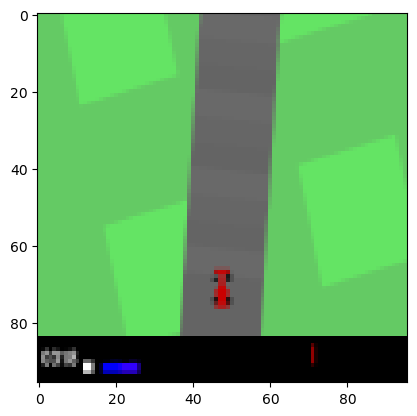

In [44]:
plt.imshow(observed_state[100])

## 2. Data Preparation for PyTorch

In this task, the generated caring car data and the respective ground-truth data will be visualized (e.g. the first 30 images). The visualization should take place after representing the data in PyTorch format. In addition, horizontal and vertical data augmentation should be implemented in the data loader. Finally, an additional augmentation for changing the street color from gray to brown should be implemented too.

*Note*: You might need to pre-process the data in advance e.g. remove any redundancy that would not contribute to learning.

*Task Output*: A data loader with horizontal, vertical and street color augmentation should be programmed. In addition, the visualization will show the images and data. Finally, it should be able to turn on / off each augmentation.



In [54]:
def removed_redundancy(action_taken,observed_state):
    non_redundant_actions_taken = []
    redundant_actions_taken = []
    index_of_non_redund_action = []
    index_of_redund_action = []
    final_states = []
    
    
    for i in range(len(action_taken)):
        if (action_taken[i] != 0).any():
            non_redundant_action = action_taken[i]
            index_number_non_redund = i
            index_of_non_redund_action.append(index_number_non_redund)
            non_redundant_actions_taken.append(non_redundant_action)
            
            
        elif (action_taken[i] == 0).all():
            redundant_action = action_taken[i]
            index_number_redund = i
            index_of_redund_action.append(i)
            redundant_actions_taken.append(redundant_action)
            
    selected_redundanct_actions=redundant_actions_taken[0:int(len(redundant_actions_taken)/5)]
    index_of_selected_redund_action=index_of_redund_action[0:int(len(redundant_actions_taken)/5)]

    
    final_selected_actions = np.concatenate([selected_redundanct_actions,non_redundant_actions_taken])
    index_of_final_selected_actions =index_of_selected_redund_action+index_of_non_redund_action
            
    
    for j in range(len(index_of_final_selected_actions)):
        state = observed_state[index_of_final_selected_actions[j]]
        final_states.append(state)
    final_states = np.array(final_states)
    
    if len(final_states)>5000:
        final_states = final_states[0:5000]
        final_selected_actions = final_selected_actions[0:5000]
    else:
        final_states = final_states
        print('States are less than 5000 enough play game again')
        final_selected_actions = final_selected_actions
        print('Action are less than 5000 enough play game again')
        
            
            
    return final_selected_actions,final_states
        
            
actions,states = removed_redundancy(action_taken,observed_state)    
print('Total number of states =', len(states))
print('Total number of Actions =', len(actions))

Total number of states = 5000
Total number of Actions = 5000


In [55]:
class customdata(Dataset):
    def __init__(self,data,labels,transform_To_Tensor=transforms.ToTensor(),
                 data_hflip=False, data_vflip=False, data_color_change=False):
        self.data=data
        self.labels=labels
        self.transform_To_Tensor=transform_To_Tensor
        self.data_hflip=data_hflip
        self.data_vflip=data_vflip
        self.data_color_change=data_color_change
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        
        
        if self.data_color_change:
            if np.random.rand()<=0.3:
                brown_color = [101, 67, 33]
                for i in range(image.shape[0]):
                    for j in range(image.shape[1]):
                        if np.array_equal(image[i,j], ([102, 102, 102] or [101, 101, 101] or 
                                                          [103, 103, 103] )):
                            image[i,j] = brown_color
                            
                            
        image = Image.fromarray(image)
        
        
        if self.data_hflip:
            hflip = torchvision.transforms.RandomHorizontalFlip(p=0.25)
            image = hflip(image)
       
        
        if self.data_vflip:
            vflip = torchvision.transforms.RandomVerticalFlip(p=0.25)
            image = vflip(image)

        image = self.transform_To_Tensor(image)

        return image, label
    
            

torch.Size([30, 3, 96, 96])
torch.Size([30, 3])


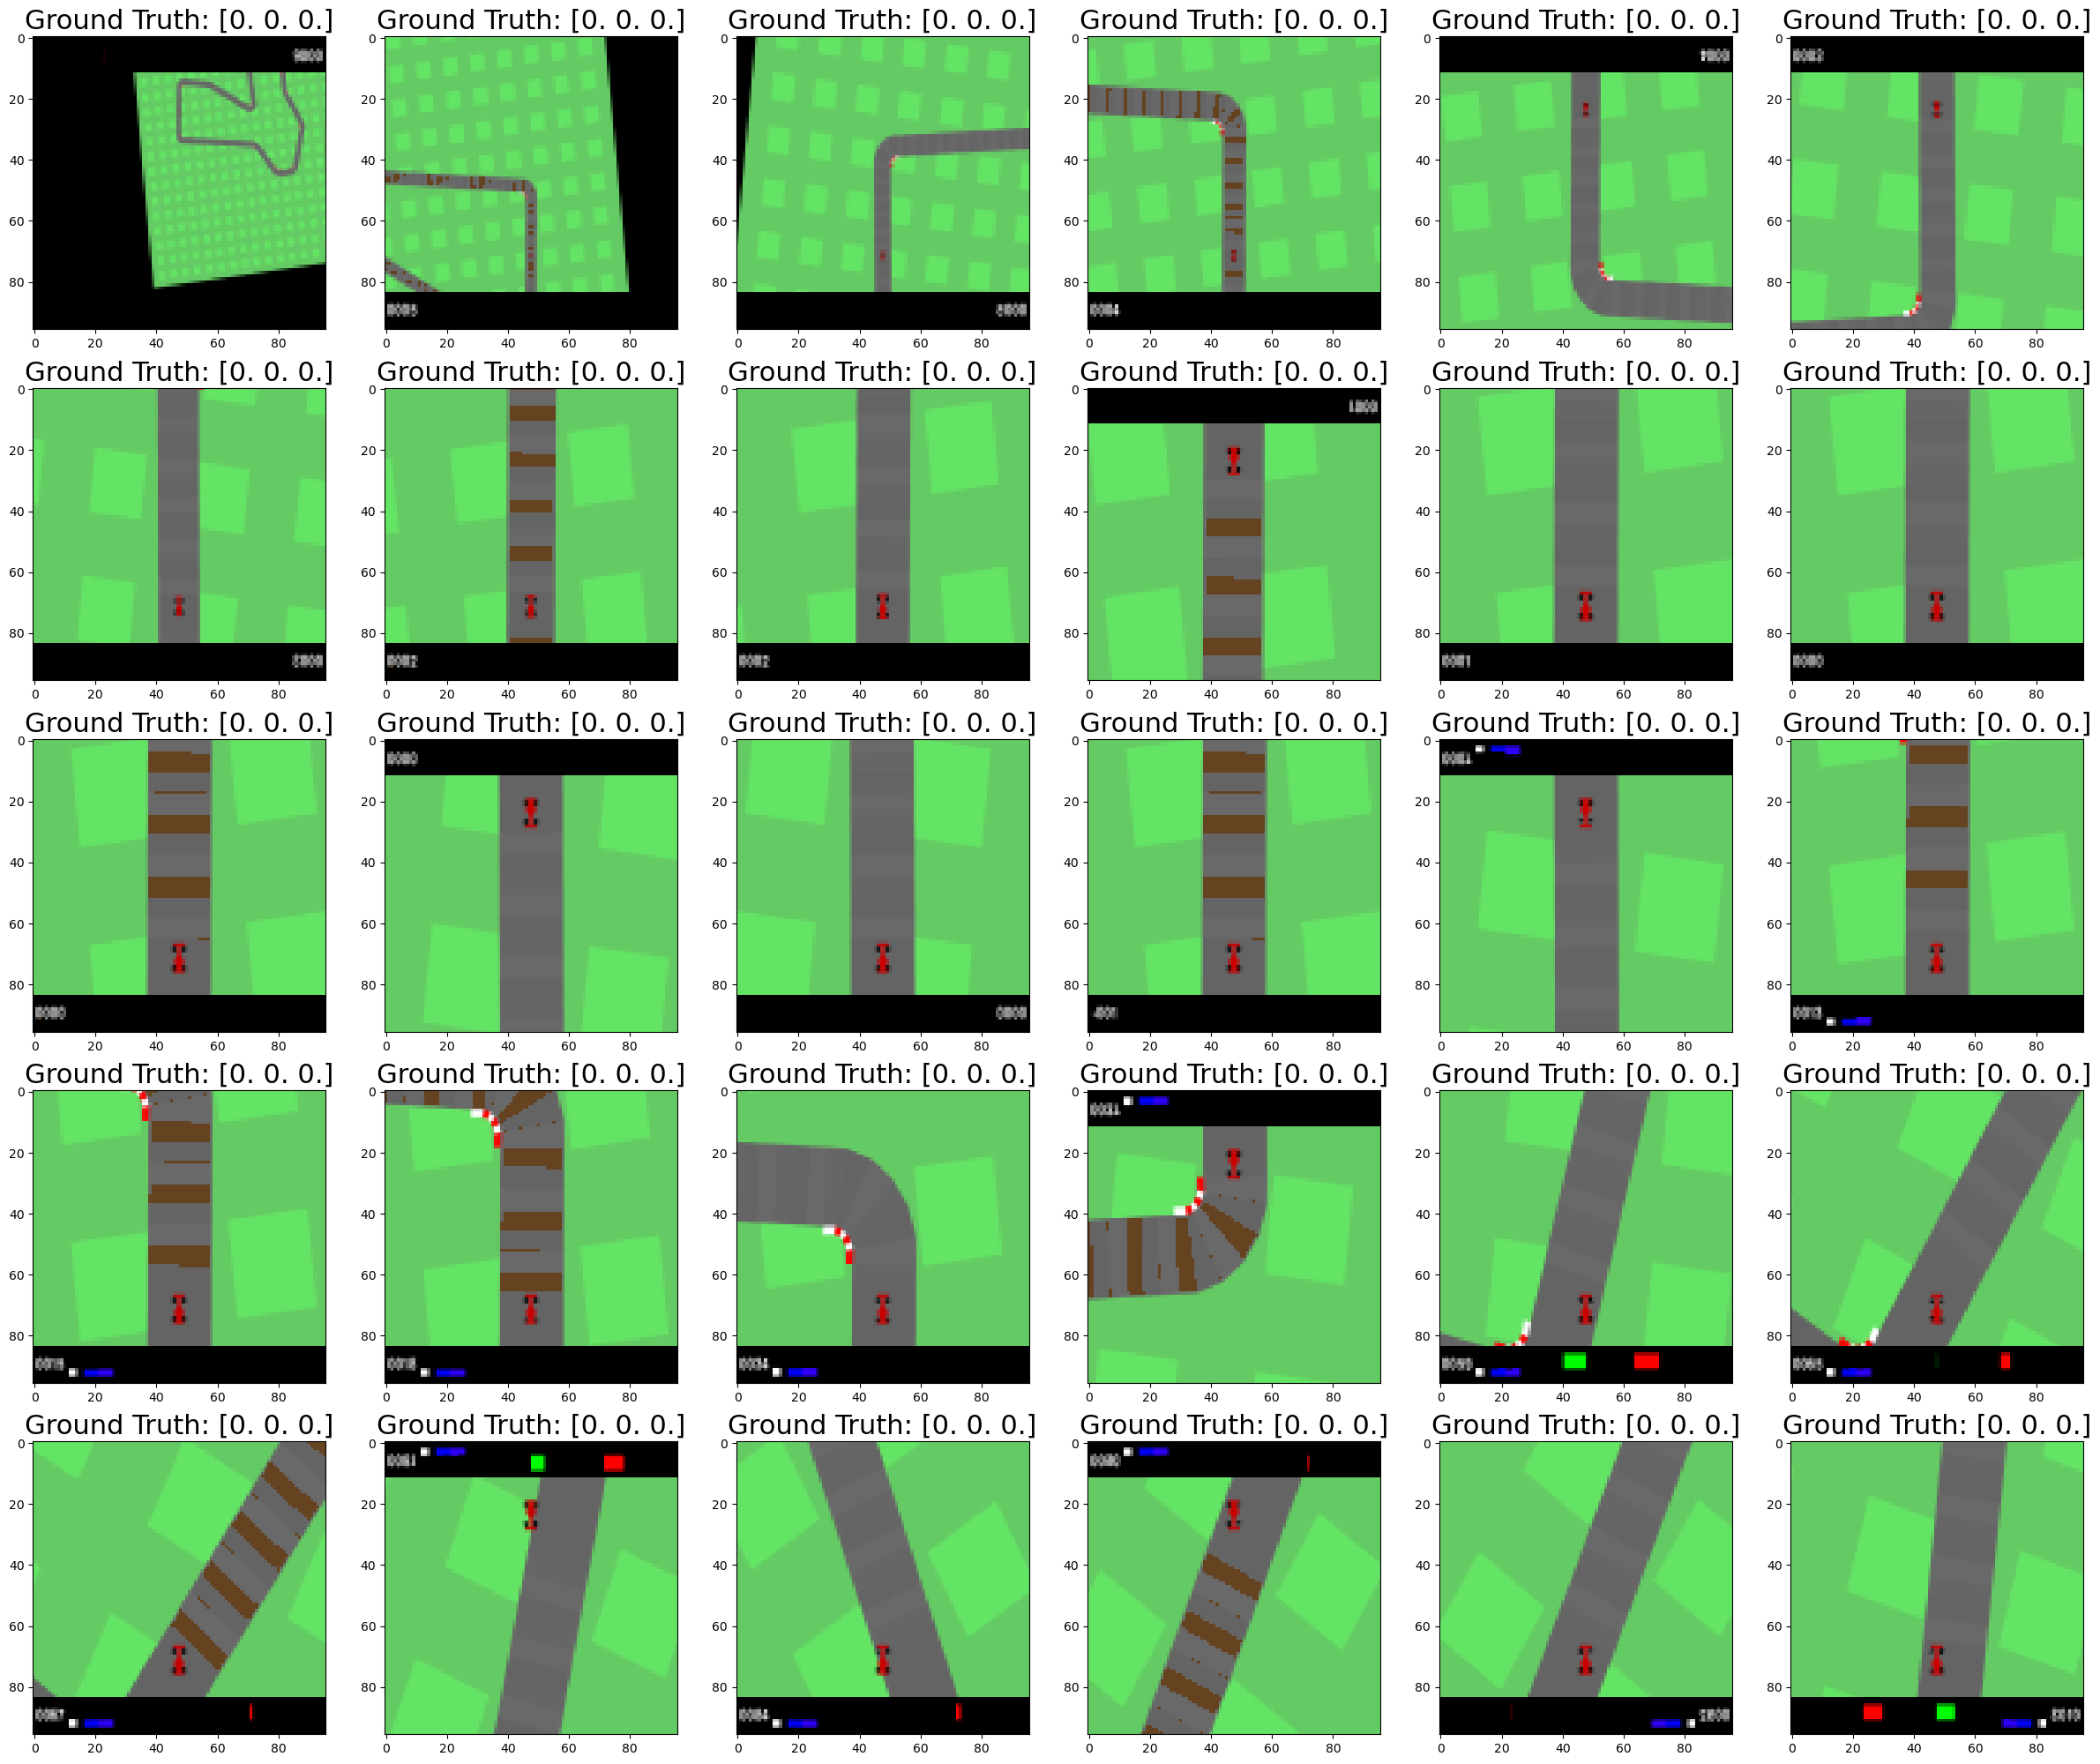

In [56]:
car_racing_data = customdata(data=states, labels=actions, 
                                 transform_To_Tensor=transforms.ToTensor(), 
                                 data_hflip=True,
                                 data_vflip=True,
                                 data_color_change=True)


batch = 30
CarRacingDataloader = DataLoader(car_racing_data, batch, shuffle=False)



for images, labels in CarRacingDataloader:
    print(images.shape)
    print(labels.shape)
    
    fig, axs = plt.subplots(5, 6, figsize=(30,25))
    axs = axs.ravel()
    
    
    
    
    for i in range(batch):
        axs[i].imshow(images[i].numpy().transpose(1,2,0))
        axs[i].set_title(("Ground Truth: " + str(labels[i].numpy())), fontsize=22)

    plt.show()
    break